# Probabilistic Hourly Load Forecasting for the German Power System Using Open Data

In the second part, I 
- Add calendar features (day-of-week, month, weekend, hour-of-day encodings).
- Add lagged and rolling-window features for load, solar, and wind.
- Construct a supervised dataset for 1-hour-ahead load forecasting.
- Perform a quick correlation check between engineered features and the target.

## 01 – Explore Time Series

In [12]:
import sys, os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Config
sns.set_context("talk")
sns.set_style("whitegrid")

# Paths and options
PROJECT_ROOT = Path.cwd()
if str(PROJECT_ROOT) not in sys.path:
    sys.path.insert(0, str(PROJECT_ROOT))
RAW_PATH = (PROJECT_ROOT / "data" / "time_series_60min_singleindex.csv")
OUT_DIR = (PROJECT_ROOT / "data" / "processed")
DATETIME_COL = "utc_timestamp"

import importlib
import src.data as data_mod
importlib.reload(data_mod)
from src.data import load_opsd_germany
from src.features import (
    add_time_features,
    add_lagged_features,
    add_rolling_features,
    make_supervised,
    make_features,
)
from src.models import train_point_model, train_quantile_models, predict_quantiles
from src.conformal import compute_absolute_residuals, conformal_interval
from src.evaluation import (
    regression_metrics,
    interval_coverage,
    interval_width,
    quantile_calibration,
    plot_quantile_calibration,
)

plt.rcParams["figure.figsize"] = (12, 4)

In [6]:
# Load OPSD Germany subset with standardized columns ['load', 'solar', 'wind']
raw = load_opsd_germany(str(RAW_PATH))
assert raw.index.is_monotonic_increasing, "Index should be sorted by time"
assert raw.index.is_unique, "Expected unique timestamps"

expected_cols = {"load", "solar", "wind"}
missing_cols = expected_cols - set(raw.columns)
assert not missing_cols, f"Missing expected columns: {missing_cols}"

print(raw.index.min(), "->", raw.index.max(), "(n=", len(raw), ")")
raw.head()

2014-12-31 23:00:00+00:00 -> 2020-09-30 23:00:00+00:00 (n= 50401 )


,load,solar,wind
utc_timestamp,,,
2014-12-31 23:00:00+00:00,NaN,NaN,NaN
2015-01-01 00:00:00+00:00,41151.0,NaN,8852.0
2015-01-01 01:00:00+00:00,40135.0,NaN,9054.0
2015-01-01 02:00:00+00:00,39106.0,NaN,9070.0
2015-01-01 03:00:00+00:00,38765.0,NaN,9163.0


#### Missing Data Diagnostics

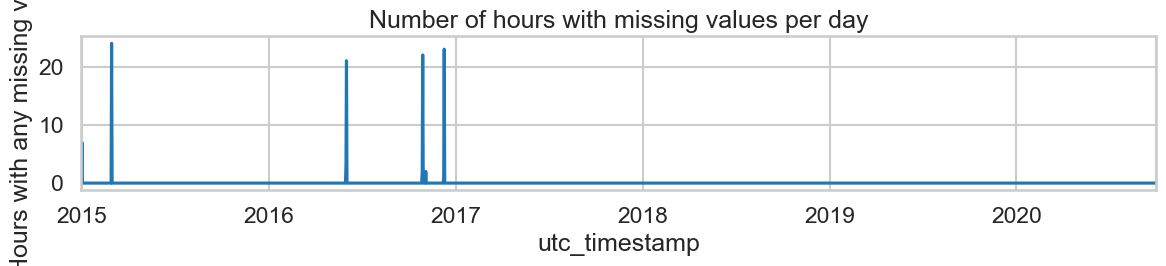

In [7]:
missing_per_day = (
    raw.isna().any(axis=1)
       .astype(int)
       .resample("D")
       .sum()
)

ax = missing_per_day.plot(kind="line", figsize=(12, 3))
ax.set_ylabel("Hours with any missing value")
plt.title("Number of hours with missing values per day")
plt.tight_layout()
plt.show()

## 02 - Feature Engineering

In [8]:
# Add time-based features
df_time = add_time_features(raw)
df_time[["load", "hour_sin", "hour_cos"]].head()
# Add lag features
df_lag = add_lagged_features(df_time, lags=(1, 2, 24, 168))
df_lag.filter(regex="load|solar|wind").head()
# Add rolling features
df_roll = add_rolling_features(df_lag)
df_roll.filter(regex="roll").head()

# Drop NaNs & inspect
df_clean = df_roll.dropna()
df_clean.head()
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 49931 entries, 2015-01-08 07:00:00+00:00 to 2020-09-30 23:00:00+00:00
Data columns (total 28 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   load                49931 non-null  float64
 1   solar               49931 non-null  float64
 2   wind                49931 non-null  float64
 3   day_of_week         49931 non-null  int32  
 4   month               49931 non-null  int32  
 5   is_weekend          49931 non-null  int64  
 6   hour_sin            49931 non-null  float64
 7   hour_cos            49931 non-null  float64
 8   load_lag_1          49931 non-null  float64
 9   load_lag_2          49931 non-null  float64
 10  load_lag_24         49931 non-null  float64
 11  load_lag_168        49931 non-null  float64
 12  solar_lag_1         49931 non-null  float64
 13  solar_lag_2         49931 non-null  float64
 14  solar_lag_24        49931 non-null  float64
 15  solar_

In [ ]:
# Create supervised dataset for 1-hour-ahead load
X_1h, y_1h = make_supervised(df_clean, horizon=1, target_col="load")
assert not X_1h.isna().any().any(), "Features contain NaNs"
assert not y_1h.isna().any(), "Targets contain NaNs"
X_1h.shape, y_1h.shape

X_1h.head(), y_1h.head()


We now have a supervised learning table where each row corresponds to time $t$, with
features summarizing the recent history and calendar context, and a target equal to
the load at time $t + 1h$. This will let us train standard regression models for
1-hour-ahead forecasting.

In [ ]:
# Quick correlation with target
corr = X_1h.assign(target=y_1h).corr()["target"].sort_values(ascending=False)
corr.head(15)

The correlation table confirms that the strongest predictors of 1-hour-ahead load are
recent load values and the same hour in the previous week, followed by daily and
weekly rolling averages. Solar-related features and hour-of-day encodings also show
moderate correlation, reflecting the alignment between daytime demand and solar
availability. This sanity check supports using these engineered features in our
forecasting models.


In [ ]:
# Save processed features
X_1h_path = (OUT_DIR / "X_load_h1.parquet")
y_1h_path = (OUT_DIR / "y_load_h1.parquet")

X_1h.to_parquet(str(X_1h_path))
y_1h.to_frame("y").to_parquet(str(y_1h_path))

## 03 – Point forecasts


In [10]:
X, y = make_features(raw, horizon=1, target_col="load")

# Time-based train/test split (80/20 by time index)
cutoff = X.index[int(0.8 * len(X))]
X_train = X[X.index < cutoff]
y_train = y[y.index < cutoff]
X_test = X[X.index >= cutoff]
y_test = y[y.index >= cutoff]
X_train.shape, X_test.shape

((39944, 28), (9986, 28))

In [13]:
# Naive baselines
# Persistence: y_hat(t+1) = load at time t
y_pred_persist = X_test["load"].values

# Same-hour-last-week: use lag_168 if available
if "load_lag_168" in X_test.columns:
    y_pred_week = X_test["load_lag_168"].values
else:
    y_pred_week = y_pred_persist.copy()

# Gradient boosting point model
point_model = train_point_model(X_train, y_train)
y_pred_gb = point_model.predict(X_test)

# Evaluate MAE & RMSE
metrics_persist = regression_metrics(y_test, y_pred_persist)
metrics_week = regression_metrics(y_test, y_pred_week)
metrics_gb = regression_metrics(y_test, y_pred_gb)

import pandas as pd
pd.DataFrame([metrics_persist, metrics_week, metrics_gb], index=["Persistence", "Same-hour-last-week", "GradientBoosting"])


,MAE,RMSE
Persistence,1880.146705,2465.128765
Same-hour-last-week,3124.026437,4575.471181
GradientBoosting,673.711326,898.088419


In [14]:
metrics_df = pd.DataFrame(
    [metrics_persist, metrics_week, metrics_gb],
    index=["Persistence", "Same-hour-last-week", "GradientBoosting"],
)

# Relative improvement vs persistence
base_mae = metrics_df.loc["Persistence", "MAE"]
base_rmse = metrics_df.loc["Persistence", "RMSE"]

metrics_df["MAE_improvement_%"] = 100 * (base_mae - metrics_df["MAE"]) / base_mae
metrics_df["RMSE_improvement_%"] = 100 * (base_rmse - metrics_df["RMSE"]) / base_rmse

metrics_df

,MAE,RMSE,MAE_improvement_%,RMSE_improvement_%
Persistence,1880.146705,2465.128765,0.000000,0.000000
Same-hour-last-week,3124.026437,4575.471181,-66.158653,-85.607796
GradientBoosting,673.711326,898.088419,64.167087,63.568296


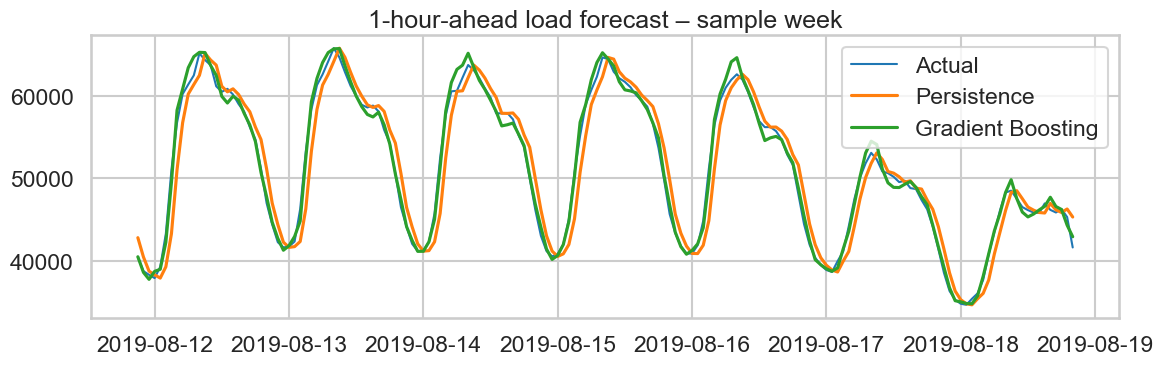

In [15]:
# Plot sample week
sample = slice(0, 7 * 24)  # first week of the test set
time = y_test.index[sample]
plt.plot(time, y_test.values[sample], label="Actual", linewidth=1.5)
plt.plot(time, y_pred_persist[sample], label="Persistence")
plt.plot(time, y_pred_gb[sample], label="Gradient Boosting")
plt.title("1-hour-ahead load forecast – sample week")
plt.legend()
plt.tight_layout()
plt.show()


The gradient boosting model (green) closely tracks the actual load curve,
capturing both the daily peaks and the overnight troughs. The persistence
baseline (orange) performs reasonably well but tends to lag during periods
of rapid change, such as the morning ramp-up and evening decline, which
leads to larger errors around the peaks and valleys. This qualitative view
is consistent with the quantitative metrics and illustrates where learned
models provide the most benefit.

In [16]:
# repeat for 24h horizon
X_24, y_24 = make_features(raw, horizon=24, target_col="load")

cutoff_24 = X_24.index[int(0.8 * len(X_24))]
X_train_24 = X_24[X_24.index < cutoff_24]
y_train_24 = y_24[y_24.index < cutoff_24]
X_test_24 = X_24[X_24.index >= cutoff_24]
y_test_24 = y_24[y_24.index >= cutoff_24]

# Baselines
y_pred_persist_24 = X_test_24["load"].values
y_pred_week_24 = X_test_24.get("load_lag_168", X_test_24["load"]).values

# Model
point_model_24 = train_point_model(X_train_24, y_train_24)
y_pred_gb_24 = point_model_24.predict(X_test_24)

# Metrics
import pandas as pd
metrics_24 = pd.DataFrame([
    regression_metrics(y_test_24, y_pred_persist_24),
    regression_metrics(y_test_24, y_pred_week_24),
    regression_metrics(y_test_24, y_pred_gb_24),
], index=["Persistence 24h", "Same-hour-last-week 24h", "GB 24h"]) 
metrics_24


,MAE,RMSE
Persistence 24h,4134.563514,6322.197120
Same-hour-last-week 24h,4894.350731,7137.936012
GB 24h,1699.169431,2462.592804


At a 24-hour horizon, all models perform worse in absolute terms, but the
relative gains from machine learning are even larger. The gradient boosting
model roughly halves both MAE and RMSE compared to the 24-hour persistence
baseline, and substantially outperforms the same-hour-last-week heuristic.
This suggests that the engineered features retain predictive value even at
longer horizons and that learned models can exploit it more effectively
than simple rules.

## 04 – Probabilistic forecasts